In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import seaborn as sns

In [2]:
# Set plotting style
plt.style.use('seaborn-white')

# Metadata saved to output plots
METADATA = {
    "Contributor": "Alexander Gude",
    "Rights": "CC-BY-SA 4.0"
}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
blue_line_color = colors[0]
orange_line_color = colors[1]
green_line_color = colors[2]

In [3]:
%matplotlib inline

In [4]:
# Show all columns
pd.set_option('display.max_columns', None)

In [5]:
START_YEAR = 2019
LAST_YEAR = 2020

DATE_COL = "collision_date"
CRASH_COL = "crashes"
FACTOR_COL = "vehicle_make"

MAKE_1 = "ford"
MAKE_2 = "toyota"

SQL_FILE = "./v2.0.0-converted_with_sts_v4.0.0-switrs.sqlite"

In [6]:
# Date conversion function
def date_columns(query):
    """If a date column is included in the query, parse it as a date in the
    dataframe."""
    dates = []
    fields = ["collision_date", "process_date"]
    if '*' in query:
        dates = fields
    else:
        for date in fields:
            if date in query:
                dates.append(date)

        if not dates:
            dates = None

    return dates

In [7]:
def run_query(query, sql_file):
    """ Read sqlite query results into a pandas DataFrame. """
    with sqlite3.connect(sql_file) as con:
        # Construct a Dataframe from the results
        df = pd.read_sql_query(
            query,
            con,
            parse_dates = date_columns(query),
        )

        return df

In [8]:
# We should be able to just set rcParams, expect Jupyter has a bug:
# https://github.com/jupyter/notebook/issues/3385
#
# So we have to call this function every time we want to plot.

def setup_plot(title=None, xlabel=None, ylabel=None):
    """Set up a simple, single pane plot with custom configuration.
    
    Args:
        title (str, optional): The title of the plot.
        xlabel (str, optional): The xlabel of the plot.
        ylabel (str, optional): The ylabel of the plot.
        
    Returns:
        (fig, ax): A Matplotlib figure and axis object.
        
    """
    # Plot Size
    plt.rcParams["figure.figsize"] = (12, 7)  # (Width, height)
    
    # Text Size
    SMALL = 12
    MEDIUM = 16
    LARGE = 20
    HUGE = 28
    plt.rcParams["axes.titlesize"] = HUGE
    plt.rcParams["figure.titlesize"] = HUGE
    plt.rcParams["axes.labelsize"] = LARGE
    plt.rcParams["legend.fontsize"] = LARGE
    plt.rcParams["xtick.labelsize"] = MEDIUM
    plt.rcParams["ytick.labelsize"] = MEDIUM
    plt.rcParams["font.size"] = SMALL
    
    # Legend
    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.framealpha"] = 1
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.edgecolor"] = "black"
    
    # Figure output
    plt.rcParams["savefig.dpi"] = 300
    
    # Make the plol
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Make the title and label area opaque instead of transparent
    fig.patch.set_facecolor(ax.get_facecolor())
    
    return fig, ax

In [9]:
def save_plot(fig, filename):
    """Save the plot with metadata and tight layout.
    
    Args:
        fig (matplotlib figure): The figure to save.
        filename (str): The loction to save the file to.
    
    """
    metadata = METADATA
    
    fig.savefig(
        fname=f"{filename}", 
        bbox_inches="tight",
        metadata=metadata,
    )

In [10]:
def normalize_dataframe(df, factor_col=FACTOR_COL, end_date='2019-07-01'):
    """Normalize the dataframe by setting the mean to 1 over the first few months."""
    ford_mean = df[(df[FACTOR_COL]=='ford') & (df.index < end_date)].mean()
    toyota_mean = df[(df[FACTOR_COL]=='toyota') & (df.index < end_date)].mean()
    
    df_normed = df.copy(deep=True)
    df_normed.loc[df[factor_col]=='ford', "total"] /= ford_mean[0]
    df_normed.loc[df[FACTOR_COL]=='toyota', "total"] /= toyota_mean[0]
    
    return df_normed

In [11]:
def make_ford_vs_toyota_plot(df, fig, ax, toyota_label_xy, ford_label_xy, stay_at_home_y, norm_label_y=None, y_lim=None, factor_col=FACTOR_COL,):

    sns.lineplot(data=df, x="collision_date", y="total", hue=factor_col, drawstyle="steps-post", linewidth=2)

    # Add labels instead of legend
    ax.get_legend().remove()
    ax.text(x=pd.Timestamp(toyota_label_xy[0]), y=toyota_label_xy[1], s="Toyota", color=orange_line_color, fontsize=30)
    ax.text(x=pd.Timestamp(ford_label_xy[0]), y=ford_label_xy[1], s="Ford", color=blue_line_color, fontsize=30)

    # Add Stay at home order
    ax.axvline(x=pd.Timestamp("2020-03-19"), color="red", linewidth=2, zorder=1, label="Stay at home order")
    ax.text(x=pd.Timestamp("2020-03-27"), y=stay_at_home_y, s="Stay-at-home Order", color="red", fontsize=24)

    
    # Add mean line
    if norm_label_y is not None:
        ax.hlines(y=1, xmin=pd.Timestamp("2019-01-01"), xmax=pd.Timestamp("2019-06-30"), linewidth=3, color=green_line_color, zorder=2)
        ax.text(x=pd.Timestamp("2018-12-14"), y=norm_label_y, s="Mean normalized from\nJanuary through June", color=green_line_color, fontsize=24)

    # Remove date label
    ax.xaxis.label.set_visible(False)
    
    if y_lim is not None:
        ax.set_ylim(*y_lim)

    return fig, ax

# Crashes by Week

Let's start by looking at the number of incidents per month:

In [12]:
query = f"""
    SELECT collision_date
        , {FACTOR_COL}
        , count(1) as total
    FROM collisions AS c
    LEFT JOIN parties as p
    ON p.case_id = c.case_id
    WHERE {DATE_COL} IS NOT NULL 
    AND {DATE_COL} BETWEEN '{START_YEAR}-01-01' AND '{LAST_YEAR}-11-30'
    AND p.{FACTOR_COL} in ('{MAKE_1}', '{MAKE_2}')
    GROUP BY 1, 2
    ORDER BY 1, total DESC
"""

df = run_query(query, SQL_FILE)

In [13]:
df_grouped = df.groupby([pd.Grouper(key=DATE_COL, freq='W-MON'), FACTOR_COL]).sum().reset_index(FACTOR_COL)

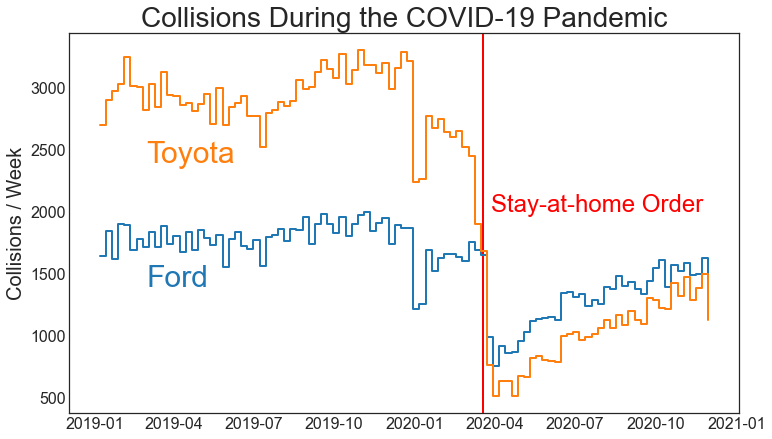

In [14]:
fig, ax = setup_plot(
    title="Collisions During the COVID-19 Pandemic",
    ylabel="Collisions / Week",
    xlabel="",
)

fig, ax = make_ford_vs_toyota_plot(
    df_grouped, fig, ax, 
    toyota_label_xy=("2019-03-01", 2400), 
    ford_label_xy=("2019-03-01", 1400), 
    stay_at_home_y=2000,
)

for ext in ("svg", "png"):
    save_plot(fig, f"/tmp/covid_pandemic_ford_vs_toyota_collisions.{ext}")

## Normalized

In [15]:
df_normed = normalize_dataframe(df_grouped)

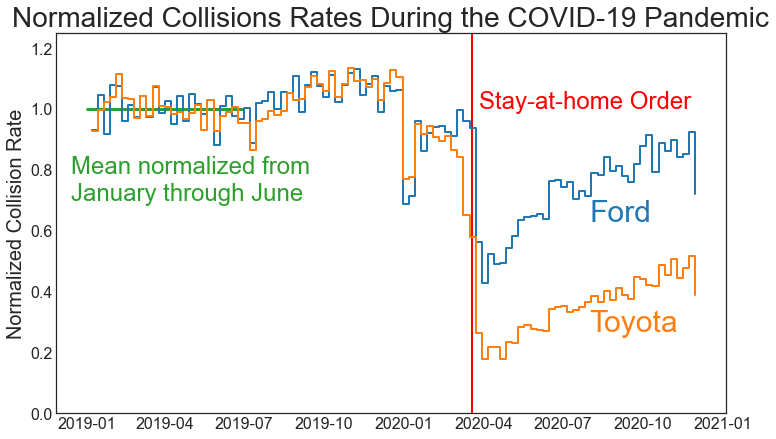

In [16]:
fig, ax = setup_plot(
    title="Normalized Collisions Rates During the COVID-19 Pandemic",
    ylabel="Normalized Collision Rate",
    xlabel="",
)

fig, ax = make_ford_vs_toyota_plot(
    df_normed, fig, ax, 
    toyota_label_xy=("2020-08-01", 0.27), 
    ford_label_xy=("2020-08-01", 0.63), 
    stay_at_home_y=1,
    norm_label_y=0.7,
    y_lim=(0, 1.25),
)

for ext in ("svg", "png"):
    file_name = f"/tmp/covid_pandemic_normalized_ford_vs_toyota_collisions.{ext}"
    save_plot(fig, file_name)

## Is this a truck thing?

In [17]:
query4 = f"""
    SELECT collision_date
        , {FACTOR_COL}
        , count(1) as total
    FROM collisions AS c
    LEFT JOIN parties as p
    ON p.case_id = c.case_id
    WHERE {DATE_COL} IS NOT NULL 
    AND {DATE_COL} BETWEEN '{START_YEAR}-01-01' AND '{LAST_YEAR}-11-30'
    AND p.{FACTOR_COL} in ('{MAKE_1}', '{MAKE_2}')
    AND statewide_vehicle_type = 'pickup or panel truck'
    GROUP BY 1, 2
    ORDER BY 1, total DESC
"""

df4 = run_query(query4, SQL_FILE)

In [18]:
df4_grouped = df4.groupby([pd.Grouper(key=DATE_COL, freq='W-MON'), FACTOR_COL]).sum().reset_index(FACTOR_COL)
df4_normed = normalize_dataframe(df4_grouped)

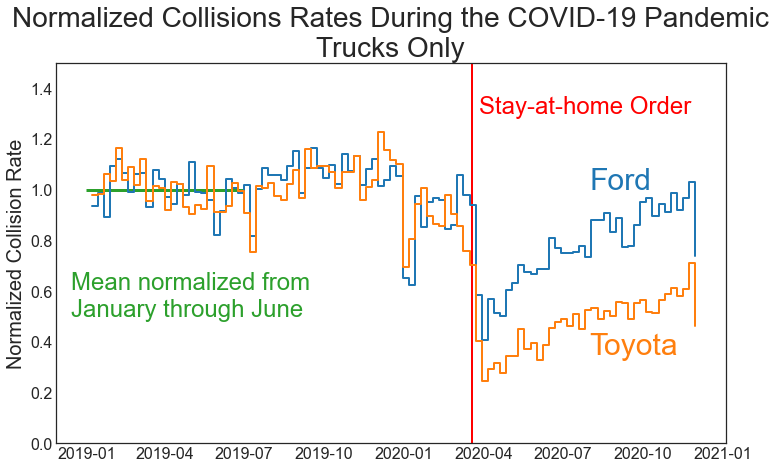

In [19]:
fig, ax = setup_plot(
    title="Normalized Collisions Rates During the COVID-19 Pandemic\nTrucks Only",
    ylabel="Normalized Collision Rate",
    xlabel="",
)

fig, ax = make_ford_vs_toyota_plot(
    df4_normed, fig, ax, 
    toyota_label_xy=("2020-08-01", 0.35), 
    ford_label_xy=("2020-08-01", 1.0), 
    stay_at_home_y=1.3,
    norm_label_y=0.5,
    y_lim=(0, 1.5),
)

for ext in ("svg", "png"):
    file_name = f"/tmp/covid_pandemic_normalized_ford_vs_toyota_collisions_trucks.{ext}"
    save_plot(fig, file_name)

## Is this a county thing?

In [20]:
query2 = f"""
    SELECT collision_date
        , {FACTOR_COL}
        , count(1) as total
    FROM collisions AS c
    LEFT JOIN parties as p
    ON p.case_id = c.case_id
    WHERE {DATE_COL} IS NOT NULL 
    AND {DATE_COL} BETWEEN '{START_YEAR}-01-01' AND '{LAST_YEAR}-11-30'
    AND p.{FACTOR_COL} in ('{MAKE_1}', '{MAKE_2}')
    AND county_location = 'contra costa'
    GROUP BY 1, 2
    ORDER BY 1, total DESC
"""

df2 = run_query(query2, SQL_FILE)

In [21]:
df2_grouped = df2.groupby([pd.Grouper(key=DATE_COL, freq='W-MON'), FACTOR_COL]).sum().reset_index(FACTOR_COL)
df2_normed = normalize_dataframe(df2_grouped)

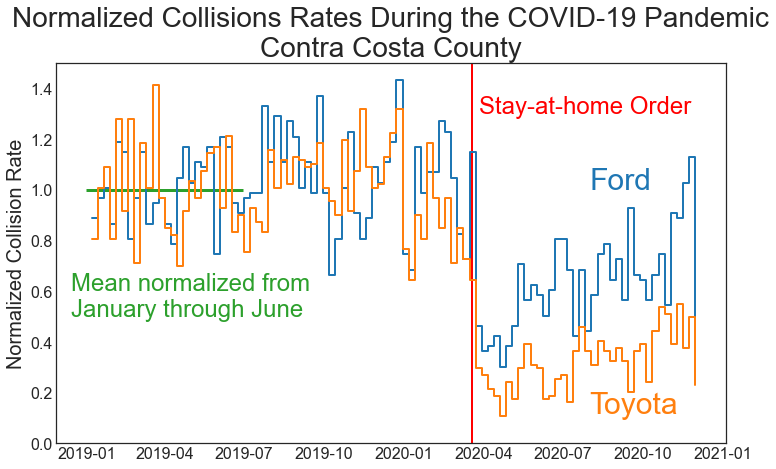

In [22]:
fig, ax = setup_plot(
    title="Normalized Collisions Rates During the COVID-19 Pandemic\nContra Costa County",
    ylabel="Normalized Collision Rate",
    xlabel="",
)

fig, ax = make_ford_vs_toyota_plot(
    df2_normed, fig, ax, 
    toyota_label_xy=("2020-08-01", 0.12), 
    ford_label_xy=("2020-08-01", 1.0), 
    stay_at_home_y=1.3,
    norm_label_y=0.5,
    y_lim=(0, 1.5),
)

for ext in ("svg", "png"):
    file_name = f"/tmp/covid_pandemic_normalized_ford_vs_toyota_collisions_contra_costa.{ext}"
    save_plot(fig, file_name)

## Is this an Age thing?

In [23]:
query3 = f"""
    SELECT collision_date
        , {FACTOR_COL}
        , party_age
    FROM collisions AS c
    LEFT JOIN parties as p
    ON p.case_id = c.case_id
    WHERE {DATE_COL} IS NOT NULL 
    AND {DATE_COL} BETWEEN '{START_YEAR}-01-01' AND '{LAST_YEAR}-11-30'
    AND p.{FACTOR_COL} in ('{MAKE_1}', '{MAKE_2}')
"""

df3 = run_query(query3, SQL_FILE)

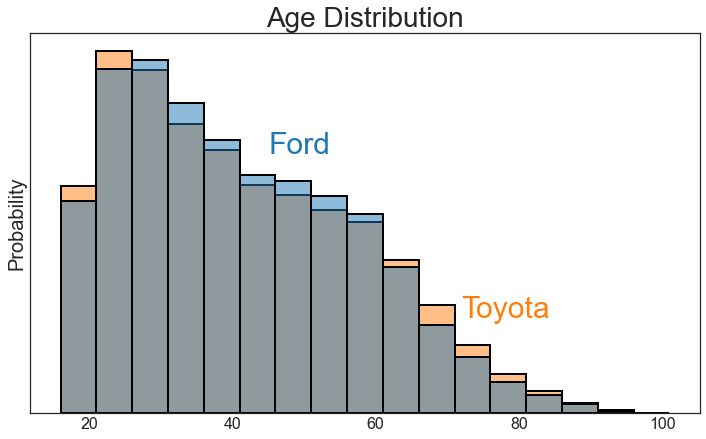

In [24]:
fig, ax = setup_plot(
    title="Age Distribution",
    ylabel="Probability",
    xlabel="",
)

sns.histplot(data=df3, x="party_age", hue=FACTOR_COL, stat="probability", common_norm=False, multiple="layer", binwidth=5, binrange=(16, 100), linewidth=2, zorder=1)

plt.tick_params(labelleft = False)

ax.text(x=72, y=0.035, s="Toyota", color=orange_line_color, fontsize=30)
ax.text(x=45, y=0.095, s="Ford", color=blue_line_color, fontsize=30)

ax.get_legend().remove()

# Remove date label
ax.xaxis.label.set_visible(False)

for ext in ("svg", "png"):
    file_name = f"/tmp/covid_pandemic_ford_vs_toyota_collisions_age_distribution.{ext}"
    save_plot(fig, file_name)

In [25]:
query5 = f"""
    SELECT collision_date
        , {FACTOR_COL}
        , count(1) as total
    FROM collisions AS c
    LEFT JOIN parties as p
    ON p.case_id = c.case_id
    WHERE {DATE_COL} IS NOT NULL 
    AND {DATE_COL} BETWEEN '{START_YEAR}-01-01' AND '{LAST_YEAR}-11-30'
    AND p.{FACTOR_COL} in ('{MAKE_1}', '{MAKE_2}')
    AND p.party_age BETWEEN 30 AND 50
    GROUP BY 1, 2
    ORDER BY 1, total DESC
"""

df5 = run_query(query5, SQL_FILE)

In [26]:
df5_grouped = df5.groupby([pd.Grouper(key=DATE_COL, freq='W-MON'), FACTOR_COL]).sum().reset_index(FACTOR_COL)
df5_normed = normalize_dataframe(df5_grouped)

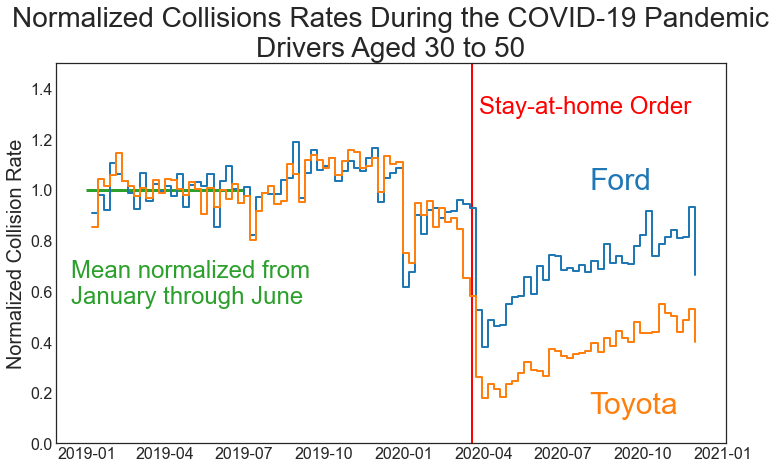

In [27]:
fig, ax = setup_plot(
    title="Normalized Collisions Rates During the COVID-19 Pandemic\nDrivers Aged 30 to 50",
    ylabel="Normalized Collision Rate",
    xlabel="", 
)

fig, ax = make_ford_vs_toyota_plot(
    df5_normed, fig, ax, 
    toyota_label_xy=("2020-08-01", 0.12), 
    ford_label_xy=("2020-08-01", 1.0), 
    stay_at_home_y=1.3,
    norm_label_y=0.55,
    y_lim=(0, 1.5),
)

for ext in ("svg", "png"):
    file_name = f"/tmp/covid_pandemic_normalized_ford_vs_toyota_collisions_age_30_to_50.{ext}"
    save_plot(fig, file_name)